Multiline model segmentation has not been great. The main hypotheses are:

- Concatenating formulas that are not that related one another does not help the model to learn the structure of the formulas.
- The model learns to interpret the patches as context keeping a left-to-right order, but without incorporating any information from vertical neighbors.


# Goal

We seek to create a model that segments multiline formulas into individual formulas via bounding box prediction. The model should be able to predict the bounding boxes of the individual formulas in the input image.

Once those bounding boxes are predicted, we segment the input image to the original model encoder and run an iterative prediction, one segmented formula at a time. This way, we can leverage the model's ability to predict the structure of the formulas.

In [1]:
%cd ..

/Users/juansegundohevia/Documents/repos/TexTract


In [2]:
import torch
import numpy as np
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Build data with bounding boxes

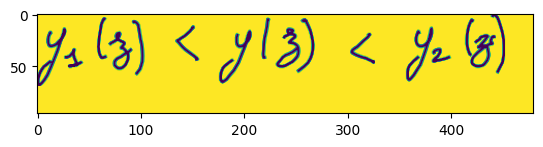

In [3]:
sample = Image.open("notebooks/sample_images/sample_image1.png")
# sample = sample.resize((256, 256))
# sample = np.array(sample)

plt.imshow(sample)

In [4]:
def pad_both_sides(img, target_h, target_w, offset_pct=0.1):
    """
    Pad an image to the target height and width on both sides.

    Returns:
    - padded_img: the padded image
    - pad_w: the width of the padding
    - pad_h: the height of the padding
    """
    if isinstance(img, Image.Image):
        img = np.array(img)
    assert isinstance(img, np.ndarray), f"Type is {type(img)}, expected np.ndarray."

    pad_h = (target_h - img.shape[0]) // 2
    pad_w = (target_w - img.shape[1]) // 2

    pad_h = np.max([0, pad_h]) + int(offset_pct * target_h)
    pad_w = np.max([0, pad_w]) + int(offset_pct * target_w)

    padded_img = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)

    return padded_img, pad_w, pad_h

def convert_to_homog_shape(img_arr, padding_offset=0.2):
    """
    Compute the maximum height and width of the images in the list
    and pad the images to the maximum height and width.
    """
    # cast all images to numpy arrays
    img_arr = [np.array(img) for img in img_arr]
    max_h = np.max([np.array(img).shape[0] for img in img_arr])
    max_w = np.max([np.array(img).shape[1] for img in img_arr])
    img_arr_padded_result = [pad_both_sides(img, max_h, max_w, offset_pct=padding_offset) for img in img_arr]
    img_arr_padded = [result[0] for result in img_arr_padded_result]
    padding_info = [result[1:] for result in img_arr_padded_result]

    # stack vertically to get to a single image
    stacked_formulas = np.vstack(img_arr_padded)
    boxes = []

    # to compute bounding boxes, we operate the padding values for each 
    # image and their original dimensions
    v_offset = 0  # vertical offset to accumulate coordinate values
    for i, (pad_w, pad_h) in enumerate(padding_info):
        h, w = img_arr[i].shape
        boxes.append([pad_w, v_offset + pad_h, w + pad_w, h + v_offset + pad_h])
        v_offset += 2 * pad_h + h  # accumulate vertical coordinate values

    return stacked_formulas, boxes

In [5]:
from pix2tex.cli import minmax_size

def resize_img_multiline(img_path):
    """
    Resize to meet multline YAML config parameters
    """
    # max_height: 192
    # max_width: 672
    # min_height: 32
    # min_width: 32
    # img = Image.open(img_path)
    img = minmax_size(img, max_dimensions=(672, 192), min_dimensions=(32, 32))
    return img

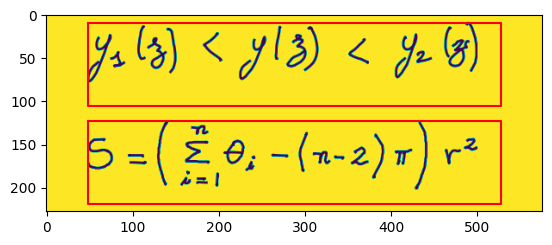

In [6]:
sample = Image.open("notebooks/sample_images/sample_image1.png")
sample2 = Image.open("notebooks/sample_images/sample_image2.png")

stacked_formulas, boxes = convert_to_homog_shape([sample, sample2], padding_offset=0.1)
stacked_formulas = minmax_size(stacked_formulas)
plt.imshow(stacked_formulas)
# plot bounding boxes
for box in boxes:
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'r-')
plt.show()

# Create dataset
Generate stacked images and their corresponding bounding boxes.

### Train Dataset

In [7]:
FORMULAE_DATAPATH = os.path.join("pix2tex","dataset", "formulae", "train")
STACKED_DATAPATH = os.path.join("formula_detector", "stacked_formulae", "train")

# create the directories if they don't exist
os.makedirs(STACKED_DATAPATH, exist_ok=True)

fnames = [os.path.join(FORMULAE_DATAPATH, f) for f in os.listdir(FORMULAE_DATAPATH) if os.path.isfile(os.path.join(FORMULAE_DATAPATH, f))]

pockets = []

# build pockets of a random number of images, from 2 to 5
while len(fnames) > 0:
    n = np.random.randint(3, 6)
    pocket = fnames[:n]
    pockets.append(pocket)
    fnames = fnames[n:].copy()

In [8]:
pocket

['pix2tex/dataset/formulae/train/0141087.png',
 'pix2tex/dataset/formulae/train/0215308.png',
 'pix2tex/dataset/formulae/train/0179518.png',
 'pix2tex/dataset/formulae/train/0074996.png',
 'pix2tex/dataset/formulae/train/0202674.png']

In [9]:
import re

In [10]:
PADDING = 0.1

def resize(img, size_th=32):
    # Assuming img is your image
    width, height = img.size
    # compute aspect ratio
    if width < height:
        new_size = (size_th, height)
    else:
        new_size = (width, size_th)

    return img.resize(new_size)
    
# match the number ID in 'pix2tex/dataset/formulae/train/0179518.png'
get_fileid = lambda fname: fname[fname.find("train/") + 6:fname.find(".png")]

stacked_data = []

for pocket in tqdm(pockets):
    try:
        imgs = [Image.open(img) for img in pocket]
    except:
        continue
    stacked_formulas, boxes = convert_to_homog_shape(imgs, padding_offset=PADDING)

    # save image
    stacked_img = Image.fromarray(stacked_formulas)
    stacked_img = minmax_size(stacked_img)
    # resize image to 32 minimum height/width
    # stacked_img = resize(stacked_img, size_th=32)

    fname = '_'.join([get_fileid(path) for path in pocket])
    stacked_img.save(os.path.join(STACKED_DATAPATH, f"{fname}.png"))

    stacked_data.append({
        "boxes": boxes,
        "images": pocket,
        "stacked_fname": f"{fname}.png"
    })

100%|██████████| 39621/39621 [02:54<00:00, 227.20it/s]


In [11]:
df_train = pd.DataFrame(stacked_data)

df_train.to_csv(os.path.join("formula_detector", "stacked_formulae", "stacked_data_train.csv"), index=False)
# save as JSON
import pickle as pkl

with open(os.path.join("formula_detector", "stacked_formulae", "stacked_data_train.pkl"), "wb") as f:
    pkl.dump(stacked_data, f)

In [12]:
df_train.head()

,boxes,images,stacked_fname
0,"[[304, 6, 464, 70], [224, 82, 544, 146], [64, ...","[pix2tex/dataset/formulae/train/0002819.png, p...",0002819_0120474_0062135_0024160.png
1,"[[48, 6, 336, 70], [48, 98, 336, 130], [32, 15...","[pix2tex/dataset/formulae/train/0169712.png, p...",0169712_0087807_0034373.png
2,"[[32, 6, 352, 70], [144, 82, 240, 146], [128, ...","[pix2tex/dataset/formulae/train/0128028.png, p...",0128028_0176632_0072326.png
3,"[[73, 6, 233, 70], [121, 98, 185, 130], [89, 1...","[pix2tex/dataset/formulae/train/0215311.png, p...",0215311_0130667_0179501_0013914_0185962.png
4,"[[320, 25, 448, 89], [144, 123, 624, 219], [64...","[pix2tex/dataset/formulae/train/0232976.png, p...",0232976_0129336_0064544_0203573.png


### Validation Dataset

In [13]:
FORMULAE_DATAPATH_VAL = os.path.join("pix2tex","dataset", "formulae", "val")
STACKED_DATAPATH = os.path.join("formula_detector", "stacked_formulae", "val")

# create the directories if they don't exist
os.makedirs(STACKED_DATAPATH, exist_ok=True)

fnames = [os.path.join(FORMULAE_DATAPATH_VAL, f) for f in os.listdir(FORMULAE_DATAPATH_VAL) if os.path.isfile(os.path.join(FORMULAE_DATAPATH_VAL, f))]

pockets = []

# build pockets of a random number of images, from 2 to 5
while len(fnames) > 0:
    n = np.random.randint(3, 6)
    pocket = fnames[:n]
    pockets.append(pocket)
    fnames = fnames[n:].copy()

In [14]:
PADDING = 0.1

stacked_data = []

get_fileid = lambda fname: fname[fname.find("val/") + 6:fname.find(".png")]


for pocket in tqdm(pockets):
    try:
        imgs = [resize(Image.open(img)) for img in pocket]
    except:
        continue
    stacked_formulas, boxes = convert_to_homog_shape(imgs, padding_offset=PADDING)

    # save image
    stacked_img = Image.fromarray(stacked_formulas)
    # resize image to 32 minimum height/width
    stacked_img = resize(stacked_img, size_th=32)
    fname = '_'.join([get_fileid(path) for path in pocket])
    stacked_img.save(os.path.join(STACKED_DATAPATH, f"{fname}.png"))

    stacked_data.append({
        "boxes": boxes,
        "images": pocket,
        "stacked_fname": f"{fname}.png"
    })

100%|██████████| 1701/1701 [00:03<00:00, 490.54it/s]


In [15]:
df_val = pd.DataFrame(stacked_data)

df_val.to_csv(os.path.join("formula_detector", "stacked_formulae", "stacked_data_val.csv"), index=False)
# save as JSON
import pickle as pkl

with open(os.path.join("formula_detector", "stacked_formulae", "stacked_data_val.pkl"), "wb") as f:
    pkl.dump(stacked_data, f)

# Create DataLoader

In [16]:
len(df_val.boxes.values[0])

5

In [17]:
from torchvision.io import read_image
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import ast


class StackedFormulasDataset(torch.utils.data.Dataset):
    """
    Dataset class for the stacked formulas.
    """

    def __init__(self, root, transforms, filepath):
        self.root = root
        self.transforms = transforms
        self.data = pd.read_csv(filepath)

        self.images = self.data["stacked_fname"].values
        self.boxes = self.data["boxes"].apply(lambda v: np.array(ast.literal_eval(v)))

    def __get_item__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        img = read_image(img_path)
        boxes = self.boxes.iloc[idx]
        
        # num objs is the number of bounding boxes
        num_objs = len(boxes)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = torch.ones((num_objs,), dtype=torch.int64)
        target["image_id"] = torch.tensor([image_id])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.images)


In [18]:
# test dataset class
ds = StackedFormulasDataset("formula_detector/stacked_formulae/train", None, "formula_detector/stacked_formulae/stacked_data_train.csv")

img, target = ds.__get_item__(0)

img.shape, target

(torch.Size([1, 304, 768]),
 {'boxes': BoundingBoxes([[304,   6, 464,  70],
                 [224,  82, 544, 146],
                 [ 64, 158, 704, 222],
                 [256, 250, 512, 282]], format=BoundingBoxFormat.XYXY, canvas_size=[304, 768]),
  'labels': tensor([1, 1, 1, 1]),
  'image_id': tensor([0]),
  'area': array([10240, 20480, 40960,  8192]),
  'iscrowd': tensor([0, 0, 0, 0])})

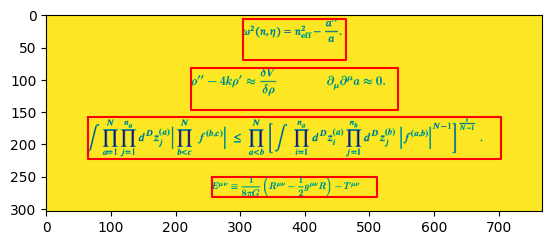

In [19]:
def plot_img_and_boxes(img, target):
    boxes = target["boxes"]
    img = F.to_pil_image(img)
    plt.imshow(img)
    for box in boxes:
        plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'r-')
    # plt.axis('off')
    plt.show()

plot_img_and_boxes(img, target)

# Get Instance of model

In [175]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [176]:
from torchvision.transforms import v2 as T

def get_transform():
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Check model and data consistency

In [177]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [137]:
pretrained_model = get_model_instance_segmentation(2)
dataset = StackedFormulasDataset("pix2tex/dataset/stacked_formulae/train", get_transform(), "pix2tex/dataset/stacked_formulae/stacked_data_train.csv")
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = pretrained_model(images, targets)  # Returns losses and detections
print(output)

# For inference
pretrained_model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = pretrained_model(x)  # Returns predictions
print(predictions[0])

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'StackedFormulasDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

# Train

In [ ]:
import wandb

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('mps')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = StackedFormulasDataset("pix2tex/dataset/stacked_formulae/train", get_transform(), "pix2tex/dataset/stacked_formulae/stacked_data_train.csv")
dataset_test = StackedFormulasDataset("pix2tex/dataset/stacked_formulae/val", get_transform(), "pix2tex/dataset/stacked_formulae/stacked_data_val.csv")

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
# num_epochs = 2

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)

print("That's it!")